## Setup

In [1]:
from qiskit import QuantumCircuit, QuantumRegister,ClassicalRegister, execute, transpile, Aer, IBMQ # circuit creation and execution
from qiskit.providers.aer.noise import NoiseModel # simulate backends
from qiskit.visualization import plot_histogram # visualize results
from qiskit.quantum_info import Statevector, state_fidelity, hellinger_fidelity # statevector and metrics
from qiskit.providers.ibmq import least_busy # get least busy device
import qiskit.tools.jupyter # visualize backends
from qiskit.circuit.library.standard_gates.rx import RXGate
# from qiskit.ignis.mitigation.measurement import complete_meas_cal,CompleteMeasFitter # measurement error mitigation

import pandas as pd # handy tools for calculation
from numpy import pi

# global vars
n = 3 # number of qubits
shots = 1000 # high number of shots per execution

## building our circuit

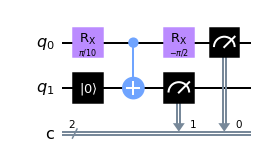

In [2]:
qreg_q = QuantumRegister(2, 'q')
creg_c = ClassicalRegister(2, 'c')
circuit = QuantumCircuit(qreg_q, creg_c)

circuit.rx(pi*1/10, qreg_q[0])
circuit.reset(qreg_q[1])
circuit.cx(qreg_q[0], qreg_q[1])
circuit.rx(-pi/2, qreg_q[0])
circuit.measure(qreg_q[1], creg_c[1])
circuit.measure(qreg_q[0], creg_c[0])
circuit.draw(output='mpl')

## conversion to qasm

In [3]:
print(circuit.qasm())

OPENQASM 2.0;
include "qelib1.inc";
qreg q[2];
creg c[2];
rx(pi/10) q[0];
reset q[1];
cx q[0],q[1];
rx(-pi/2) q[0];
measure q[1] -> c[1];
measure q[0] -> c[0];



## printing plot of basic circuit

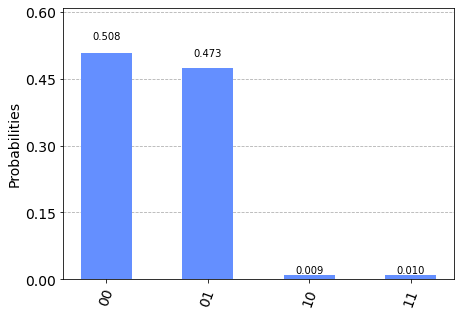

In [4]:
# Running the basic bomb tester circuit

from qiskit.providers.aer import QasmSimulator
simulator = QasmSimulator()

job = simulator.run(circuit, shots=1000)
result = job.result()
counts = result.get_counts(circuit)

from qiskit.visualization import plot_histogram
plot_histogram(counts)

## state accuracy of four different optimizations

In [5]:
expected_states = ['00', '01', '10', '11']  # target states

def get_state_accuracy(counts): # funciton to calculate state accuracy
    expected_counts = 0
    for state in counts.keys():
        if state in expected_states:
            expected_counts = expected_counts + counts[state]
    state_accuracy = expected_counts / shots
    return str(state_accuracy*100)+"%"

# accuracy with perfect backend

In [6]:
counts = execute(circuit, backend=Aer.get_backend('qasm_simulator'), shots=shots).result().get_counts() # execution on simulator
state_accuracy = get_state_accuracy(counts)
print(f"state accuracy on the simulator: {state_accuracy}")

state accuracy on the simulator: 100.0%


## importing mock devices to test

In [7]:
from qiskit.test.mock import *

backends = [FakeVigo()]
backend1 = FakeVigo()

## results_backends

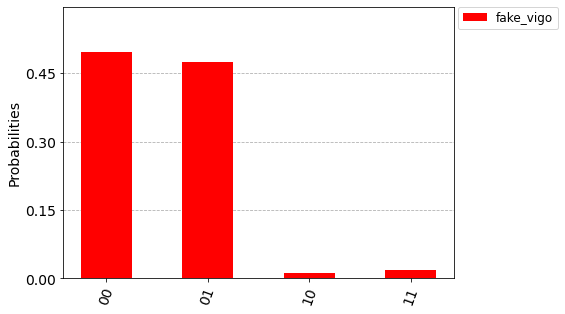

In [8]:
results_backends = []

for backend in backends:
    counts = execute(circuit, backend=backend, shots=shots, optimization_level=0).result().get_counts() # get results
    state_accuracy = get_state_accuracy(counts) # calculate state accuracy
    results_backends.append((backend.name(), counts, state_accuracy)) # store results
    
# plot results
plot_histogram([counts for backend_name, counts, state_accuracy in results_backends],
                legend=[backend_name for backend_name, counts, state_accuracy in results_backends],
                sort="asc",
                color=["red", "orange", "yellow", "green", "blue", "violet", "purple", "black"],
                bar_labels=False)

## creating coupling map optimised circuit

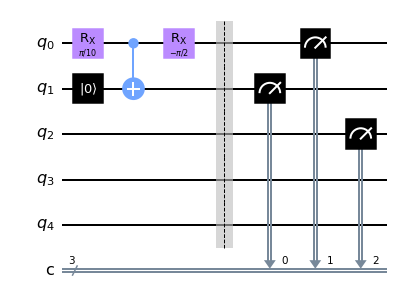

In [9]:
# backend1: create coupling map optimised circuit

# map: qubit 0 -> qubit 1
# qubit 1 -> qubit 0
# qubit 2 -> qubit 2
qreg_q = QuantumRegister(2, 'q')
creg_c = ClassicalRegister(2, 'c')
circuit = QuantumCircuit(qreg_q, creg_c)

circuit_backend1 = QuantumCircuit(5,3, name=f"GHZ yyx {backend1.name()} optimized") # note that we use 5 qubits here to match the configuration of the device
circuit_backend1.rx(pi/10,0)  # we map qubit 0 to qubit 1 and qubit 1 to qubit 0 ..
circuit_backend1.reset(1) # .. to ensure that all logical CNOT gates are performed on physical connections
circuit_backend1.cx(0,1)
circuit_backend1.rx(-pi/2,0)
circuit_backend1.barrier()
circuit_backend1.measure([1,0,2], range(n)) 
circuit_backend1.draw("mpl")

## results_backend1_coupling

In [10]:
# compare results between original and coupling map optimized circuit on backend1
results_backend1_coupling = []

circuits = [circuit, circuit_backend1]
for circuit in circuits:
    transpiled_circuit = transpile(circuit, backend=backend1, optimization_level=0)
    counts = execute(circuit, backend=backend1, shots=shots, optimization_level=0).result().get_counts() # get results
    state_accuracy = get_state_accuracy(counts) # calculate state accuracy
    results_backend1_coupling.append((circuit.name, counts, state_accuracy)) # store
    

print("State Accuracy \n"+
      "\n".join([str(circuit_name)+': '+str(state_accuracy) 
                 for circuit_name, counts, state_accuracy in results_backend1_coupling]))

plot_histogram([counts for circuit_name, counts, state_accuracy in results_backend1_coupling],
               legend=[circuit_name for circuit_name, counts, state_accuracy in results_backend1_coupling],
               title=backend1.name(),
               bar_labels=False)

QiskitError: 'No counts for experiment "0"'

In [ ]:
# compare results from different optimization levels on backend 1
results_backend1_transpiler = []

optimization_levels = [0,1,2,3]
#print(ghz)
for optim_level in optimization_levels:
    transpiled_circuit = transpile(circuit, backend=backend1, optimization_level=optim_level)
    #print(transpiled_circuit)
    counts = execute(circuit, backend=backend1, shots=shots, optimization_level=optim_level).result().get_counts() # get results
    state_accuracy = get_state_accuracy(counts) # calculate state accuracy
    results_backend1_transpiler.append((optim_level, counts, state_accuracy)) # store
    
# compare state accuracies
print("State Accuracy \n"+
      "\n".join(["optimization_level_"+str(optim_level)+': '+str(state_accuracy) 
                 for optim_level, counts, state_accuracy in results_backend1_transpiler]))

# plot results
plot_histogram([counts for optim_level, counts, state_accuracy in results_backend1_transpiler],
               legend=["optimization_level_"+str(optim_level) for optim_level, counts, state_accuracy in results_backend1_transpiler],
               title=backend1.name(),
               bar_labels=False)